## Load features dataset

In [1]:
import numpy as np
import pandas as pd
import os
import re
import joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
features_folder = '/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Dataset/1_Processed/CSI_Features/2-seconds-updated'
features_list = [f for f in os.listdir(features_folder) if f.endswith('.csv')]

dfs = []
for file_name in features_list:
    # We will use data of day 1 and 2 for cross validation
    match = re.search(r"csi-features-final-d(\d+)-(\d+)", file_name)
    if match:
      print(file_name)
      label = match.group(2)
      print("label:", label)
      file_path = os.path.join(features_folder, file_name)
      df = pd.read_csv(file_path)
      df["label"] = int(label)
      dfs.append(df)
print("Number of dataframes loaded: ", len(dfs))

csi-features-final-d1-0.csv
label: 0
csi-features-final-d1-1.csv
label: 1
csi-features-final-d1-2.csv
label: 2
csi-features-final-d1-3.csv
label: 3
csi-features-final-d1-4.csv
label: 4
csi-features-final-d1-5.csv
label: 5
csi-features-final-d2-0.csv
label: 0
csi-features-final-d2-1.csv
label: 1
csi-features-final-d2-2.csv
label: 2
csi-features-final-d2-3.csv
label: 3
csi-features-final-d2-4.csv
label: 4
csi-features-final-d2-5.csv
label: 5
csi-features-final-d3-0.csv
label: 0
csi-features-final-d3-1.csv
label: 1
csi-features-final-d3-2.csv
label: 2
csi-features-final-d3-3.csv
label: 3
csi-features-final-d3-4.csv
label: 4
csi-features-final-d3-5.csv
label: 5
Number of dataframes loaded:  18


## Split and stratify

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer

In [5]:
df_fea_all = pd.DataFrame()

for i in range(len(dfs)):
    df_fea_all = pd.concat([df_fea_all, dfs[i]], axis=0)

df_fea_all.reset_index(drop=True)


,std_subcarrier_0,mean_subcarrier_0,max_subcarrier_0,min_subcarrier_0,qtu_subcarrier_0,qtl_subcarrier_0,iqr_subcarrier_0,std_subcarrier_1,mean_subcarrier_1,max_subcarrier_1,...,adj_subcarrier_41,adj_subcarrier_42,adj_subcarrier_43,adj_subcarrier_44,adj_subcarrier_45,adj_subcarrier_46,adj_subcarrier_47,adj_subcarrier_48,euc,label
0,2.458781,18.741377,23.436087,12.873449,20.788364,16.796083,3.992281,2.175019,18.433488,22.899534,...,4.242609,7.725777,4.387893,4.157481,2.961773,3.508334,3.186696,3.576259,3.911264,0
1,1.982891,20.387290,26.262447,14.678144,21.650830,19.327499,2.323331,1.839736,19.941909,24.315708,...,4.296441,6.981031,4.177062,4.234196,3.672567,3.835890,4.142555,4.031667,4.005180,0
2,2.532899,19.210716,24.707508,11.948169,21.059424,17.626041,3.433383,2.301174,18.658401,24.315708,...,5.086393,7.053560,4.864779,4.436664,4.104615,4.844086,5.216937,4.654624,4.243677,0
3,1.386501,17.874270,21.470917,14.713286,18.848673,16.946680,1.901993,1.583156,17.751923,21.570862,...,4.461256,7.767771,4.261174,4.017492,3.862723,4.494754,4.508927,3.997518,3.899283,0
4,1.468549,16.473418,20.004469,13.289907,17.542516,15.450712,2.091804,1.342521,16.696228,20.489609,...,4.241535,8.114839,4.819547,4.449275,3.433007,4.036137,3.518238,3.760217,3.689709,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565,9.831218,21.280484,67.261770,10.161172,22.105522,15.159076,6.946445,9.039429,20.230853,64.053100,...,4.118862,6.974629,5.008503,5.316596,4.957762,5.448862,5.030393,4.529632,4.594068,5
3566,3.000602,17.352482,25.557821,10.161172,19.717701,15.052845,4.664857,2.546410,16.534993,24.855629,...,3.999402,7.081345,4.523281,4.170807,4.370057,4.733311,4.558936,4.076752,3.959692,5
3567,1.928810,16.298398,22.953371,10.376799,17.660007,14.865142,2.794866,2.333736,15.918993,24.619368,...,4.364184,8.167755,5.119288,4.066608,3.549240,3.239923,3.351568,2.953703,3.765696,5
3568,2.217180,18.214112,23.766727,13.020193,19.349277,17.179911,2.169366,2.028640,17.828399,23.847166,...,4.013827,7.076097,4.661318,4.493716,4.161460,4.593099,4.566673,4.027329,4.204345,5


In [6]:
# set k for k-hold cross-validation
k = 7

X = df_fea_all.drop('label', axis=1)
y = df_fea_all['label']

X = X.reset_index()
X = X.drop('index', axis = 1)
y = y.reset_index()
y = y.drop('index', axis = 1)

# imputer = SimpleImputer(strategy='mean')
# X = imputer.fit_transform(X)
# X = pd.DataFrame(X)

skf = StratifiedKFold(n_splits=k)

train_index = [[] for _ in range(k)]
test_index = [[] for _ in range(k)]

n = 0
for tra_idx, tes_idx in skf.split(X,y):

    print('##### Stratified k-fold',n+1,'#####')
    print("TRAIN: ",len(tra_idx))
    print("TEST: ",len(tes_idx))

    train_index[n] = tra_idx
    test_index[n] = tes_idx

    n += 1

##### Stratified k-fold 1 #####
TRAIN:  3060
TEST:  510
##### Stratified k-fold 2 #####
TRAIN:  3060
TEST:  510
##### Stratified k-fold 3 #####
TRAIN:  3060
TEST:  510
##### Stratified k-fold 4 #####
TRAIN:  3060
TEST:  510
##### Stratified k-fold 5 #####
TRAIN:  3060
TEST:  510
##### Stratified k-fold 6 #####
TRAIN:  3060
TEST:  510
##### Stratified k-fold 7 #####
TRAIN:  3060
TEST:  510


## DNNR Training

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [8]:
early_stopping =  EarlyStopping(
                            monitor='val_mae',
                            min_delta=0,
                            patience=100,
                            verbose=1,
                            mode='auto')

In [9]:
def compare_TV(history, train_met, val_met):
    acc = history.history[train_met]
    val_acc = history.history[val_met]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo' ,label = 'training '+train_met)
    plt.plot(epochs, val_acc, 'b' , label= 'validation '+val_met)
    plt.title('Training and Validation metrics')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.8278 - mae: 1.5077 - val_loss: 1.6540 - val_mae: 0.9792
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5492 - mae: 0.9340 - val_loss: 1.1166 - val_mae: 0.7698
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1406 - mae: 0.7886 - val_loss: 0.9856 - val_mae: 0.7243
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9435 - mae: 0.7154 - val_loss: 0.8118 - val_mae: 0.6762
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8942 - mae: 0.6980 - val_loss: 1.0170 - val_mae: 0.7497
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8347 - mae: 0.6677 - val_loss: 0.7551 - val_mae: 0.6548
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7077 - mae: 0.6207 - val_loss: 0.7321 - val_mae: 0.6313
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7442 - mae: 0.6245 - val_loss: 0.6252 - val_mae: 0.5923
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 

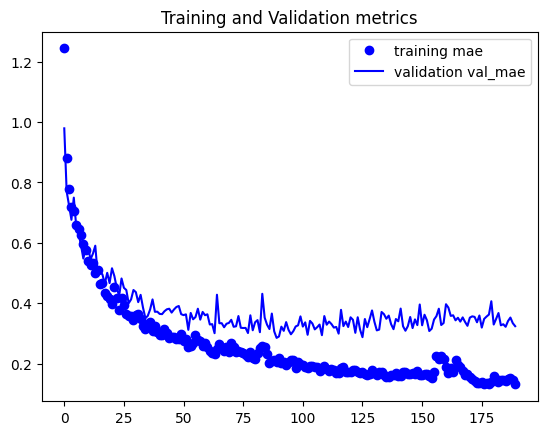

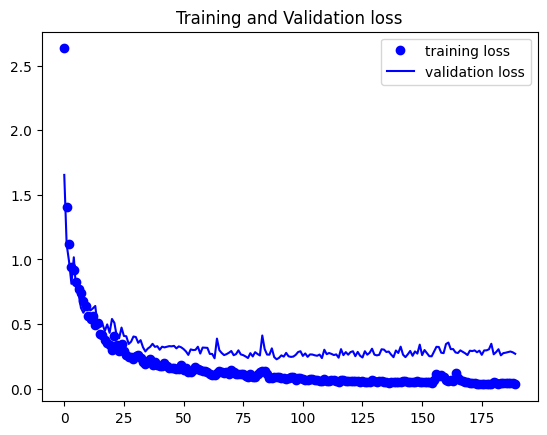

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold 1 completed with MAE: 0.7104398012161255
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.6018 - mae: 1.8390 - val_loss: 1.5398 - val_mae: 0.9562
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7477 - mae: 1.0142 - val_loss: 1.1055 - val_mae: 0.7964
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2760 - mae: 0.8600 - val_loss: 1.0165 - val_mae: 0.7795
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1719 - mae: 0.8098 - val_loss: 1.0436 - val_mae: 0.7706
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9215 - mae: 0.7192 - val_loss: 0.9113 - val_mae: 0.7115
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9582 - mae: 0.7207 - val_loss: 0.9503 - val_mae: 0.7234
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9233 - mae: 0.7172 - val_loss: 0.7540 - val_mae: 0.6457
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7482 - mae: 0.6331 - val_loss: 0.8569 - val_mae: 0.6898
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 

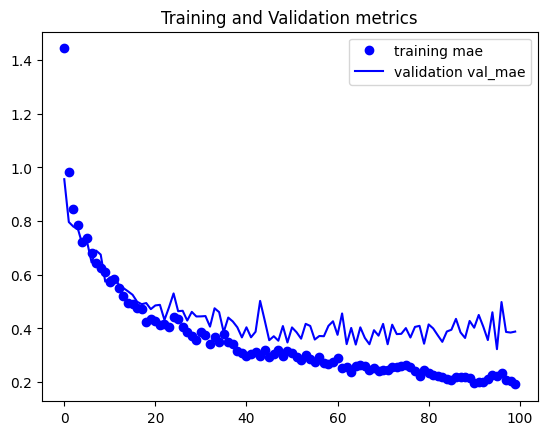

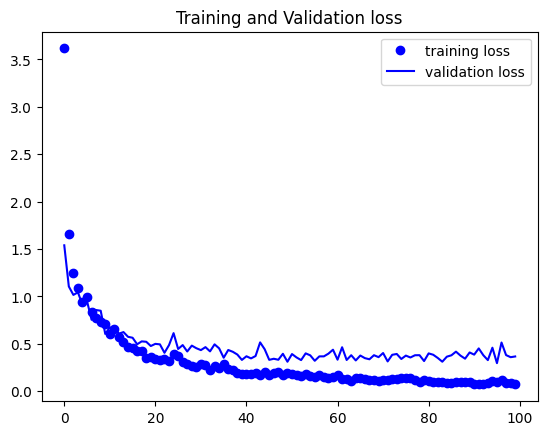

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold 2 completed with MAE: 0.4916410446166992
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 4.0261 - mae: 1.4859 - val_loss: 1.5882 - val_mae: 0.9297
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.4468 - mae: 0.9075 - val_loss: 1.2017 - val_mae: 0.8268
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.1361 - mae: 0.7987 - val_loss: 0.9386 - val_mae: 0.7352
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.0828 - mae: 0.7850 - val_loss: 0.9943 - val_mae: 0.7541
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9825 - mae: 0.7413 - val_loss: 0.8216 - val_mae: 0.6733
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9077 - mae: 0.7056 - val_loss: 0.8730 - val_mae: 0.6959
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7949 - mae: 0.6657 - val_loss: 0.7864 - val_mae: 0.6665
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6972 - mae: 0.6137 - val_loss: 0.7205 - val_mae: 0.6100
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 

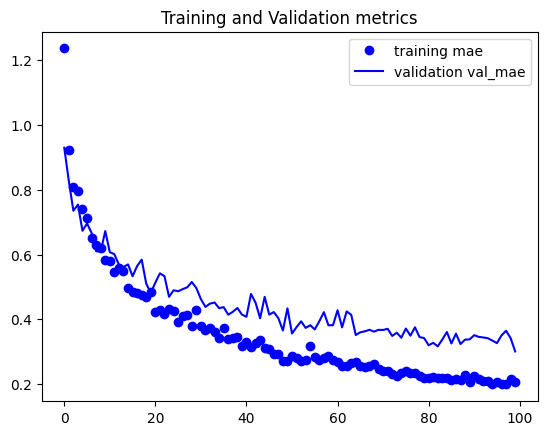

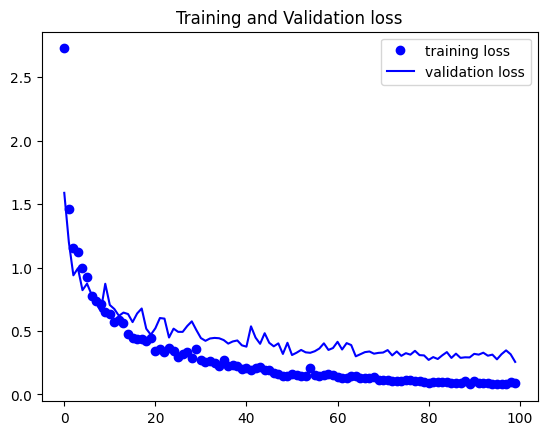

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold 3 completed with MAE: 0.12791502475738525
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.0859 - mae: 1.5605 - val_loss: 1.4133 - val_mae: 0.9206
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.6486 - mae: 0.9709 - val_loss: 1.2630 - val_mae: 0.8404
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2135 - mae: 0.8208 - val_loss: 1.0394 - val_mae: 0.7666
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.0940 - mae: 0.7853 - val_loss: 0.8368 - val_mae: 0.6784
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9585 - mae: 0.7207 - val_loss: 0.7268 - val_mae: 0.6602
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9149 - mae: 0.7228 - val_loss: 0.7737 - val_mae: 0.6408
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8181 - mae: 0.6652 - val_loss: 0.8856 - val_mae: 0.6912
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7955 - mae: 0.6511 - val_loss: 0.7304 - val_mae: 0.6320
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 

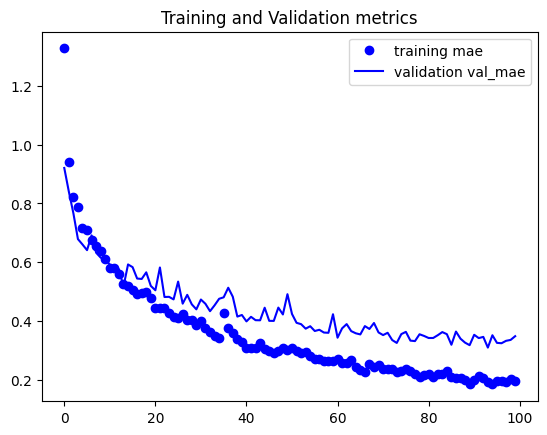

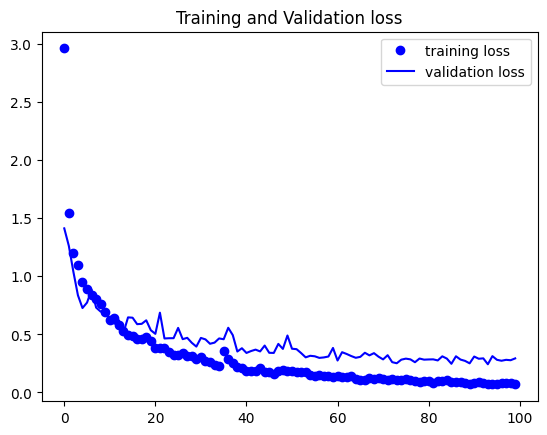

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Fold 4 completed with MAE: 0.08668175339698792
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3.6231 - mae: 1.4650 - val_loss: 1.4425 - val_mae: 0.9406
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5278 - mae: 0.9514 - val_loss: 1.1855 - val_mae: 0.8554
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.4691 - mae: 0.9127 - val_loss: 1.0624 - val_mae: 0.7786
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1454 - mae: 0.7975 - val_loss: 0.8841 - val_mae: 0.7155
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9920 - mae: 0.7441 - val_loss: 0.8870 - val_mae: 0.7178
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9208 - mae: 0.7252 - val_loss: 0.8005 - val_mae: 0.6630
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8485 - mae: 0.6886 - val_loss: 0.8584 - val_mae: 0.7220
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7731 - mae: 0.6486 - val_loss: 0.7105 - val_mae: 0.6443
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 

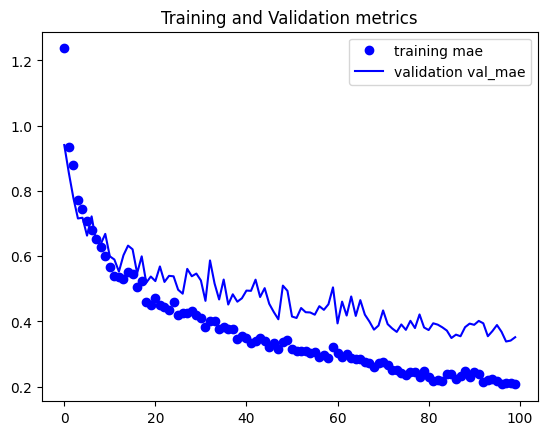

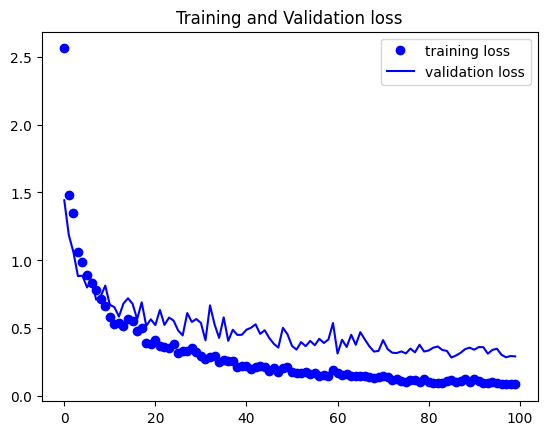

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Fold 5 completed with MAE: 0.12434136867523193
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 4.0298 - mae: 1.5369 - val_loss: 1.5439 - val_mae: 0.9737
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.6479 - mae: 0.9871 - val_loss: 1.1072 - val_mae: 0.7956
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2349 - mae: 0.8334 - val_loss: 0.8405 - val_mae: 0.6925
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.0164 - mae: 0.7479 - val_loss: 0.8011 - val_mae: 0.6707
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.9033 - mae: 0.7073 - val_loss: 0.9586 - val_mae: 0.7205
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8292 - mae: 0.6806 - val_loss: 0.7402 - val_mae: 0.6434
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7349 - mae: 0.6372 - val_loss: 0.7118 - val_mae: 0.6101
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7583 - mae: 0.6441 - val_loss: 0.8111 - val_mae: 0.6513
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 

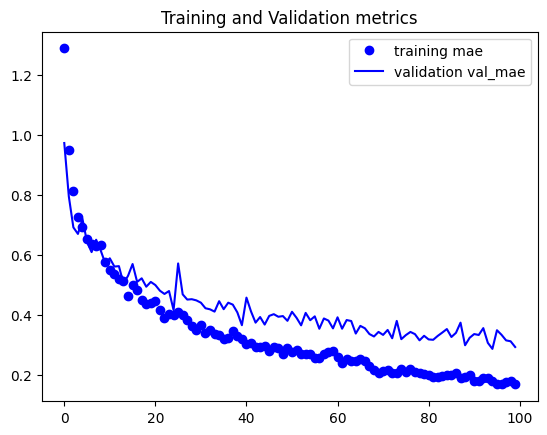

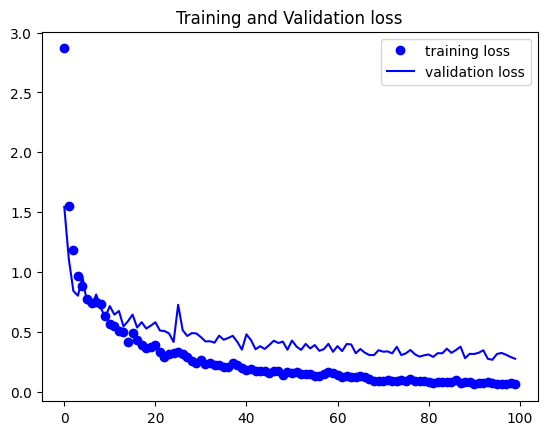

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 6 completed with MAE: 0.5997462272644043
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.0195 - mae: 1.5330 - val_loss: 1.4170 - val_mae: 0.9159
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.5951 - mae: 0.9501 - val_loss: 1.0961 - val_mae: 0.7713
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.3014 - mae: 0.8444 - val_loss: 0.8276 - val_mae: 0.6795
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9401 - mae: 0.7198 - val_loss: 0.8089 - val_mae: 0.6690
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9327 - mae: 0.7052 - val_loss: 0.7234 - val_mae: 0.6155
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7536 - mae: 0.6327 - val_loss: 0.6659 - val_mae: 0.5879
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7234 - mae: 0.6161 - val_loss: 0.6318 - val_mae: 0.5618
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.6395 - mae: 0.5798 - val_loss: 0.5507 - val_mae: 0.5294
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 

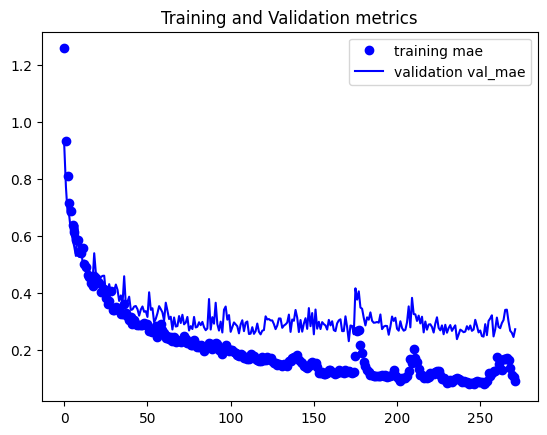

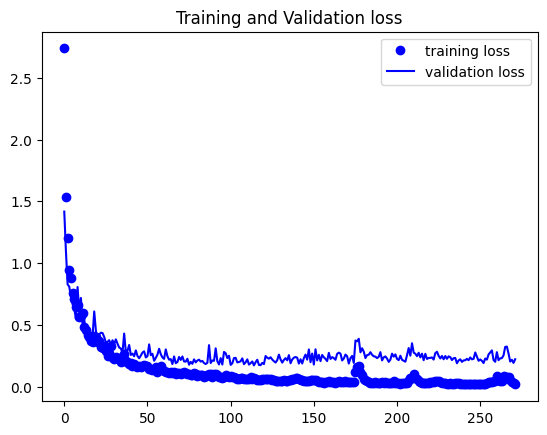

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 7 completed with MAE: 0.9185425043106079
Median Absolute Error for each fold: [0.7104398012161255, 0.4916410446166992, 0.12791502475738525, 0.08668175339698792, 0.12434136867523193, 0.5997462272644043, 0.9185425043106079]


In [10]:
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import median_absolute_error

# Initialize lists to store results
y_test_list = [[] for _ in range(k)]
y_pred_list = [[] for _ in range(k)]
mae_list = []  # To store the MAE for each fold

for i in range(k):
    # Split data into training and test sets
    X_train = X.iloc[train_index[i]]
    X_test = X.iloc[test_index[i]]
    y_train = y.iloc[train_index[i]]
    y_test = y.iloc[test_index[i]]

    # Further split X_train and y_train into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=100, stratify=y_train)

    # Feature standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert transformed arrays back to DataFrames (if necessary)
    X_train = pd.DataFrame(X_train)
    X_val = pd.DataFrame(X_val)
    X_test = pd.DataFrame(X_test)

    # Define the model
    model = Sequential()
    model.add(Dense(1000, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))

    # Compile the model
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])

    # Fit the model
    history = model.fit(
        X_train, y_train,
        batch_size=100,
        epochs=1000,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks=(early_stopping)
    )

    # Visualize the training and validation MAE
    compare_TV(history, "mae", "val_mae")

    # Make predictions
    y_pred = model.predict(X_test)

    # Save model and scaler
    model.save(f'/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Models/1611_model_fold_{i+1}.keras')
    joblib.dump(scaler, f'/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Models/1611_scaler_fold_{i+1}.pkl')

    # Calculate and store the median absolute error for the fold
    fold_mae = median_absolute_error(y_test, y_pred)
    mae_list.append(fold_mae)

    # Save the test and prediction results for each fold
    y_test_list[i] = y_test
    y_pred_list[i] = y_pred

    print(f"Fold {i+1} completed with MAE: {fold_mae}")

# Print all MAEs
print("Median Absolute Error for each fold:", mae_list)


## Evaluation

In [11]:
for i in range(len(y_test_list)):
    y_test_list[i] = y_test_list[i].values

In [12]:
y_test_tot = []
y_pred_tot = []

for i in range(k):
    y_test_tot.extend(y_test_list[i])
    y_pred_tot.extend(y_pred_list[i])

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

In [14]:
# result scores

print('DNN')
print('###########################')
print('Med-abs-err: ',round(median_absolute_error(y_test_tot, y_pred_tot),4))
print('Max-err: ',round(max_error(y_test_tot, y_pred_tot),4))
print('R2_score: ',round(r2_score(y_test_tot, y_pred_tot),4))
print('###########################')

DNN
###########################
Med-abs-err:  0.2659
Max-err:  4.4929
R2_score:  0.7433
###########################
